<a href="https://colab.research.google.com/github/vaneesa-writes/micro_project/blob/main/stained_nuclei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
from skimage.measure import label, regionprops
import cv2

In [4]:
# import shutil
# import os

# # path to source directory
# src_dir = '/content/drive/MyDrive/dataset/data_science_bowl/modified/h&e_stained_mask'

# # path to destination directory
# dest_dir = '/content/sample_data/h&e_stained_mask'

# # getting all the files in the source directory
# files = os.listdir(src_dir)

# shutil.copytree(src_dir, dest_dir)

'/content/sample_data/h&e_stained_mask'

In [38]:
TRAIN_PATH = '/content/sample_data/h&e_stained/'
TEST_PATH = '/content/sample_data/h&e_test/'

train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

['8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b.jpg', '6b0ac2ab04c09dced54058ec504a4947f8ecd5727dfca7e0b3f69de71d0d31c7.jpg', 'b214800de5ed4cc558f44d569495970f93c8c047f8e464c51d4bd5c276118423.jpg', '8f27ebc74164eddfe989a98a754dcf5a9c85ef599a1321de24bcf097df1814ca.jpg', 'be771d6831e3f8f1af4696bc08a582f163735db5baf9906e4729acc6a05e1187.jpg', '54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12.jpg', '0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e.jpg', '15039b3acccc4257a1a442646a89b6e596b5eb4531637e6d8fa1c43203722c99.jpg', '5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e.jpg', '947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050.jpg', '9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944.jpg', '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed.jpg', 'ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548.jpg', '7798ca1ddb3133563e290c36228bc8f8f3c9f224e096f442ef0653856662d1

In [32]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
BATCH_SIZE = 32
seed = 42

In [33]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [35]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
 # print(id_)
  path = TRAIN_PATH 
  img = imread(path + id_)[:,:,:IMG_CHANNELS]  
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n] = img 
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  mask_ = imread('/content/sample_data/h&e_stained_mask/'+ id_)
  mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                    preserve_range=True), axis=-1)
  mask = np.maximum(mask, mask_)             
  Y_train[n] = mask

100%|██████████| 124/124 [00:02<00:00, 46.85it/s]


In [39]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH 
    img = imread(path +  id_ )[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

100%|██████████| 18/18 [00:01<00:00, 16.87it/s]


In [40]:
def draw_sub_plots(n,m,X,Y):
  f, axarr = plt.subplots(n,m,figsize=((10, 10)))
  ind=0
  for row in range(n):
    for col in range(m):
      if(col%2==0):
        img = X[row].reshape((128,128,3))
        axarr[row, 0].axis("off")
        axarr[row,0].imshow(img)
        title = "Train Image "+str(row+1)
        title_color = 'black'
        title = axarr[row, 0].set_title(title)
        plt.setp(title, color=title_color)
    else:
      img = Y[row]
      axarr[row, 1].axis("off")
      axarr[row,1].imshow(img)
      title = "Ground Truth Image "+str(row+1)
      title_color = 'black'
      title = axarr[row, 1].set_title(title)
      plt.setp(title, color=title_color)

In [41]:
X=[]
Y=[]
for ind in range(4):
  i = random.randint(0, len(train_ids))
  X.append(X_train[i])
  Y.append(np.squeeze(Y_train[i]))

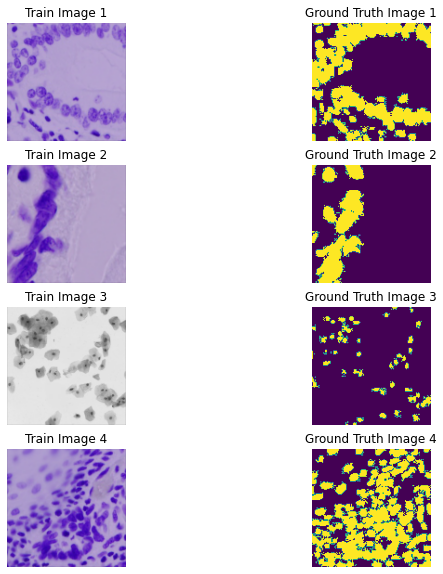

In [42]:
draw_sub_plots(4,2,X,Y)

In [43]:
from keras.preprocessing import image

image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

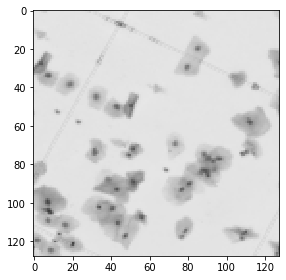

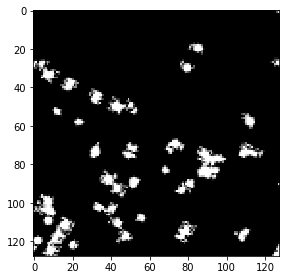

In [44]:
imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0]))
plt.show()

In [45]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [46]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

In [47]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [48]:
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=3, callbacks=[earlystopper, checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/3
250/250 [==============================] - ETA: 0s - loss: 0.2798 - mean_io_u: 0.3797
Epoch 00001: val_loss improved from inf to 0.19874, saving model to model-dsbowl2018-1.h5
250/250 [==============================] - 80s 269ms/step - loss: 0.2798 - mean_io_u: 0.3797 - val_loss: 0.1987 - val_mean_io_u: 0.4118
Epoch 2/3
250/250 [==============================] - ETA: 0s - loss: 0.1995 - mean_io_u: 0.3797
Epoch 00002: val_loss improved from 0.19874 to 0.17033, saving model to model-dsbowl2018-1.h5
250/250 [==============================] - 55s 219ms/step - loss: 0.1995 - mean_io_u: 0.3797 - val_loss: 0.1703 - val_mean_io_u: 0.4118
Epoch 3/3
250/250 [==============================] - ETA: 0s - loss: 0.1989 - mean_io_u: 0.3797
Epoch 00003: val_loss improved from 0.17033 to 0.14591, saving model to model-dsbowl2018-1.h5
250/250 [==============================] - 55s 221ms/step - loss: 0.1989 - mean_io_u: 0.3797 - val_loss: 0.1459 - val_mean_io_u: 0.4118


In [49]:
from keras.models import Model, load_model
model = load_model('model-dsbowl2018-1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

1/1 [==============================] - 1s 814ms/step


In [50]:
def draw_sub_plots_3(n,m,X,Y,Pred,name=True):
  f, axarr = plt.subplots(n,m,figsize=((15, 15)))
  ind=0
  for row in range(n):
    for col in range(m):
      if(col==0):
        img = X[row].reshape((128,128,3))
        axarr[row, 0].axis("off")
        axarr[row,0].imshow(img)
        title = "Train Image "+str(row+1)
        title_color = 'black'
        title = axarr[row, 0].set_title(title)
        plt.setp(title, color=title_color)
      
      elif(col==1):
        img = Y[row]
        axarr[row, 1].axis("off")
        axarr[row,1].imshow(img)
        if(name):
          title = "Ground Truth Image "+str(row+1)
        else:
          title = "Predicted Mask "+str(row+1)
        title_color = 'black'
        title = axarr[row, 1].set_title(title)
        plt.setp(title, color=title_color)
      else:
        img = Pred[row]
        axarr[row, 2].axis("off")
        axarr[row,2].imshow(img)
        title = "Predicted Image "+str(row+1)
        title_color = 'black'
        title = axarr[row, 2].set_title(title)
        plt.setp(title, color=title_color)

In [51]:
X=[]
Y=[]
draw_over=[]
gt=[]
for ind in range(4):
  i = random.randint(0, len(train_ids))
  X.append(X_train[i])
  gt.append(Y_train[i])
  Y.append(resize(np.squeeze(preds_train_t[i]), (128, 128), mode='constant', preserve_range=True))
  image = np.squeeze(preds_train_t[i])
  img_1=X_train[i].copy()
  lbl_0 = label(image) 
  props = regionprops(lbl_0)
  for prop in props:
    cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 1)
  draw_over.append(img_1)

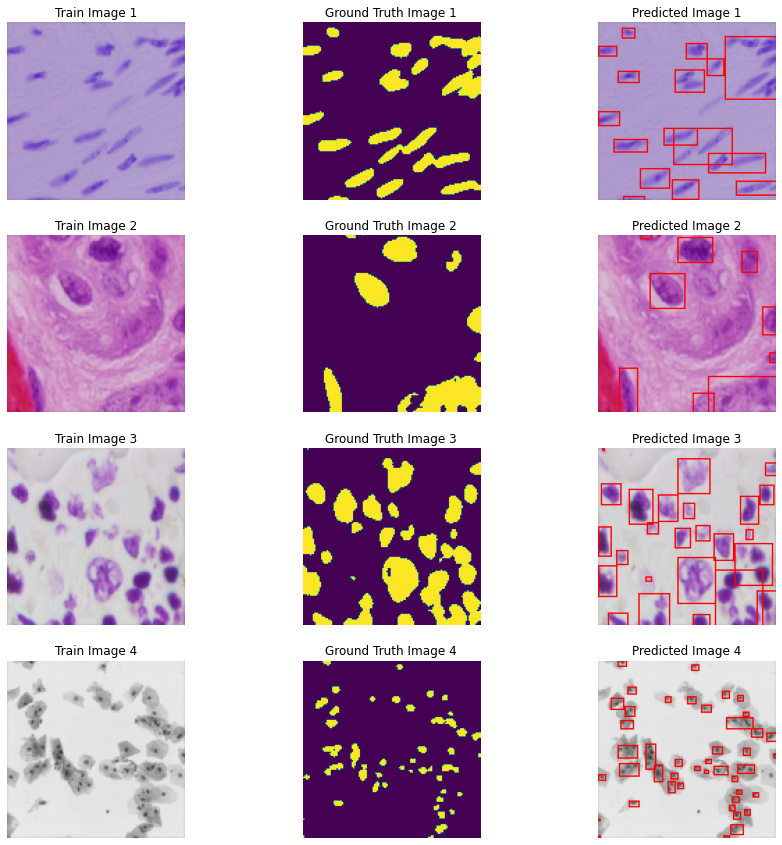

In [52]:
draw_sub_plots_3(4,3,X,Y,draw_over)

In [53]:
X=[]
Y=[]
draw_over=[]
for ind in range(4):
  i = random.randint(0, len(test_ids))
  X.append(X_test[i])
  Y.append(resize(np.squeeze(preds_test_t[i]), (128, 128), mode='constant', preserve_range=True))
  image = np.squeeze(preds_test_t[i])
  img_1=X_test[i].copy()
  lbl_0 = label(image) 
  props = regionprops(lbl_0)
  for prop in props:
    cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 1)
  draw_over.append(img_1)

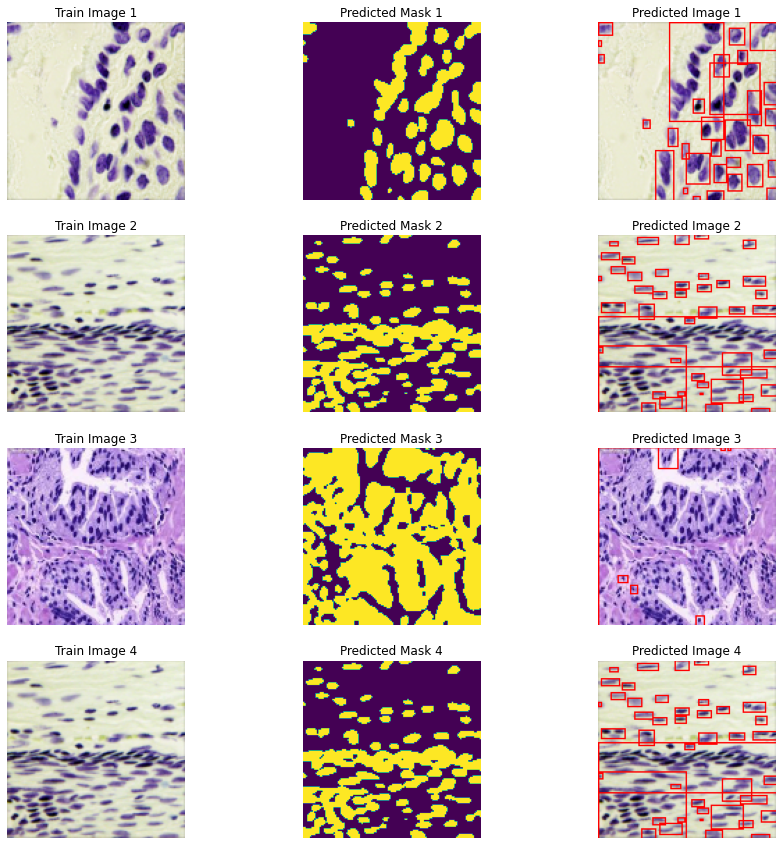

In [54]:
draw_sub_plots_3(4,3,X,Y,draw_over,False)